In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Susmita_Final_dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Susmita_Final_dataset.zip')
f.keys()
!unzip "Susmita_Final_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5055.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5056.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5057.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5058.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5059.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5061.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5062.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5064.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5065.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5066.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing5067.jpg  
  inflating: Susmita's_Finaldataset/train/Rail crossing/Rail crossing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
train_dir = "/content/Susmita's_Finaldataset/train"
validation_dir = "/content/Susmita's_Finaldataset/val"
test_dir = "/content/Susmita's_Finaldataset/test"

BATCH_SIZE = 32
IMG_SIZE = (250, 250)
no_classes = 13

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6468 files belonging to 13 classes.
Found 1814 files belonging to 13 classes.
Found 930 files belonging to 13 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomZoom(height_factor=0.2)
    ],
    name="img_augmentation",
)

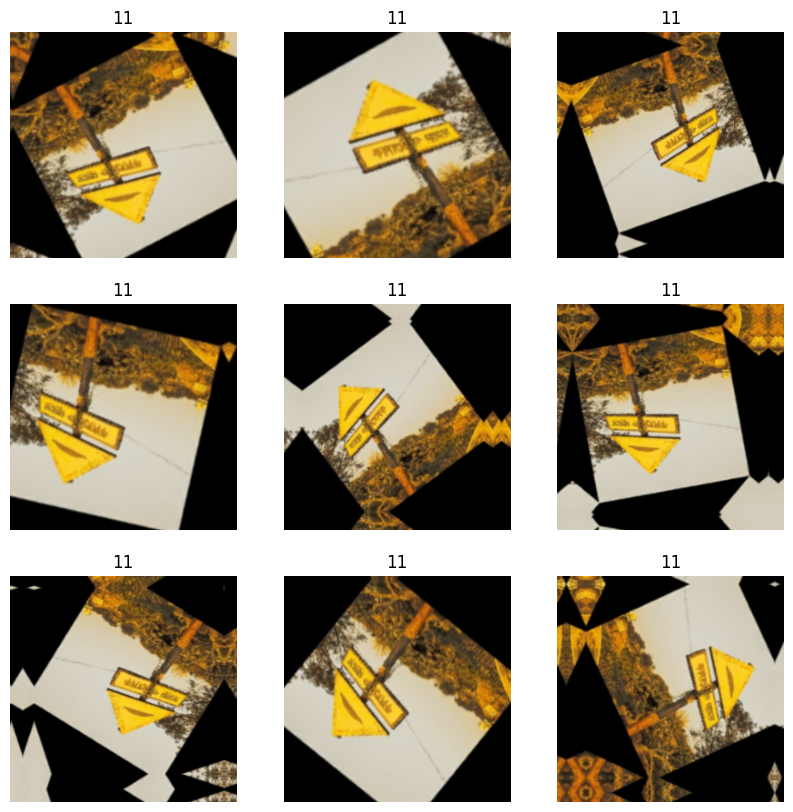

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.Xception(
    weights=None,  
    input_shape=(250, 250, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
nb_classes = 13
inputs = keras.Input(shape=(250, 250, 3))
x = img_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 250, 250, 3)      0         
 l)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               104908

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy']) 

In [ ]:
epochs = 60
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/60
203/203 [==============================] - 189s 694ms/step - loss: 2.5619 - accuracy: 0.0799 - val_loss: 2.5581 - val_accuracy: 0.0854
Epoch 2/60
203/203 [==============================] - 137s 672ms/step - loss: 2.5246 - accuracy: 0.1175 - val_loss: 2.4886 - val_accuracy: 0.1488
Epoch 3/60
203/203 [==============================] - 135s 665ms/step - loss: 2.4461 - accuracy: 0.1552 - val_loss: 2.3760 - val_accuracy: 0.1775
Epoch 4/60
203/203 [==============================] - 135s 663ms/step - loss: 2.3758 - accuracy: 0.1846 - val_loss: 2.2589 - val_accuracy: 0.2144
Epoch 5/60
203/203 [==============================] - 134s 660ms/step - loss: 2.3093 - accuracy: 0.2081 - val_loss: 2.2663 - val_accuracy: 0.2205
Epoch 6/60
203/203 [==============================] - 134s 660ms/step - loss: 2.1718 - accuracy: 0.2452 - val_loss: 2.2578 - val_accuracy: 0.2883
Epoch 7/60
203/203 [==============================] - 133s 656ms/step - loss: 2.0805 - accuracy: 0.2822 - val_loss: 1.9613 -

In [ ]:
scores = model.evaluate(test_dataset)

30/30 [==============================] - 6s 168ms/step - loss: 0.1456 - accuracy: 0.9645


In [ ]:
class_names = test_dataset.class_names
class_names

['College in front',
 'Crossdroad',
 'Left turn',
 'Market in front',
 'Mosque in front',
 'Pedestrian crossing',
 'Rail crossing',
 'Right turn',
 'School in front',
 'Side road lef',
 'Side road right',
 'Speed breaker',
 'Speed limit']

first image to predict
actual label: Speed breaker
1/1 [==============================] - 1s 744ms/step
predicted label: Speed breaker


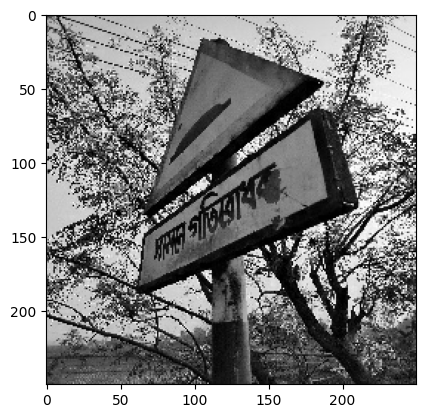

In [ ]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


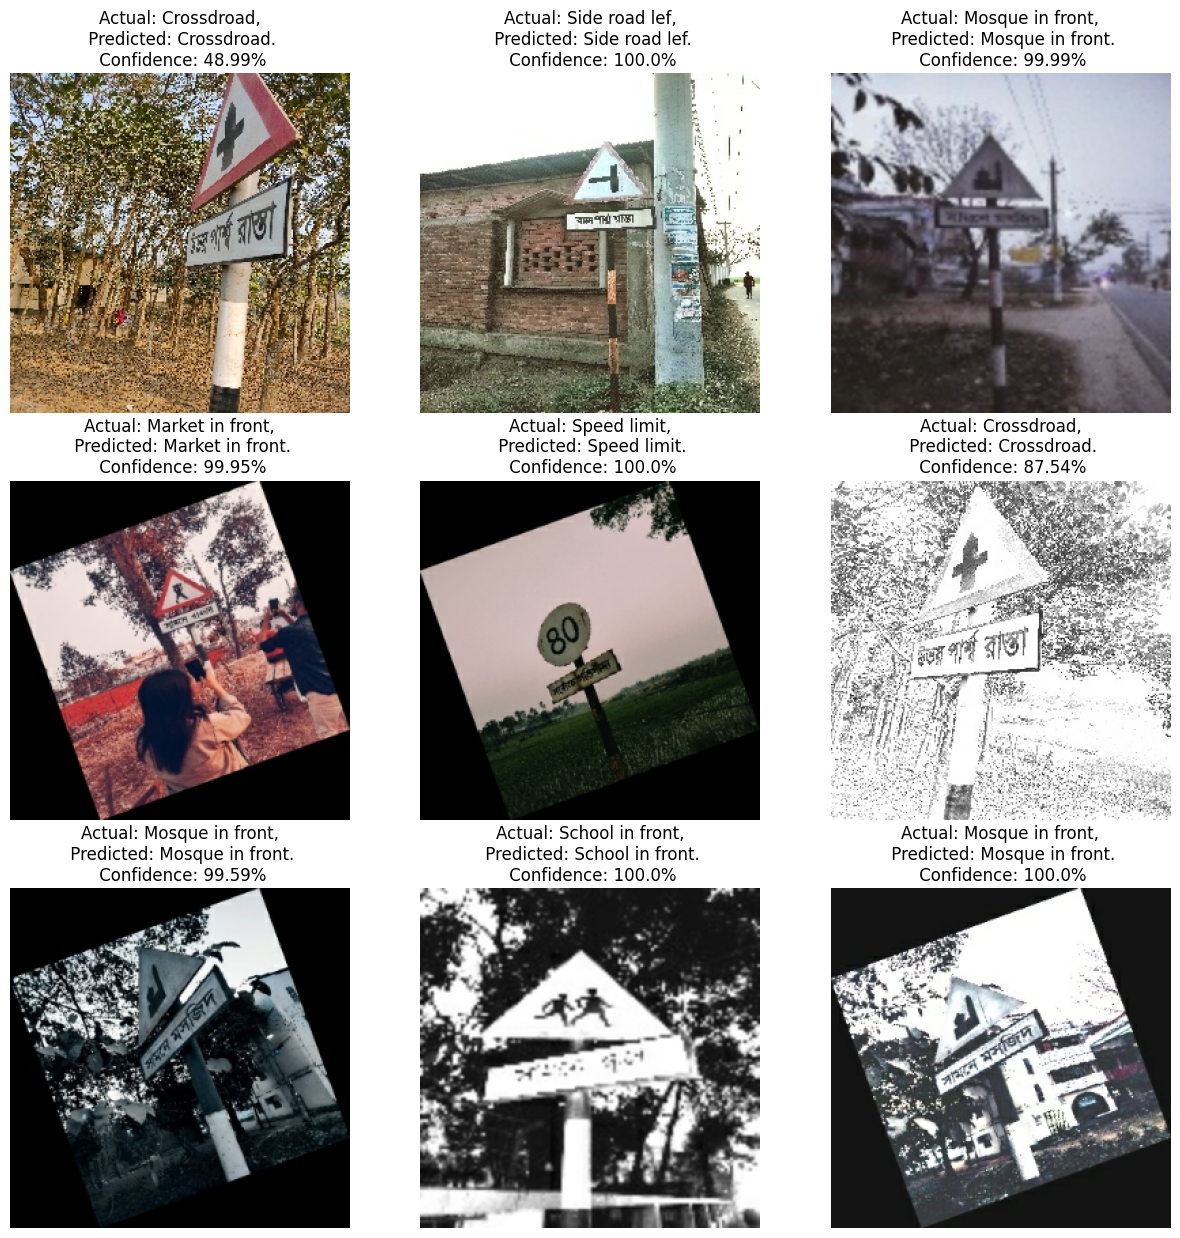

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('test.zip')
f.keys()
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/IMG20230228181526.jpg  
  inflating: test/IMG20230228181936.jpg  
  inflating: test/IMG20230228181937.jpg  
  inflating: test/IMG_20230228_153940.jpg  
  inflating: test/IMG_20230228_154105 (2).jpg  
  inflating: test/IMG_20230228_154121 (2).jpg  
  inflating: test/IMG_20230228_154132.jpg  
  inflating: test/IMG_20230228_154413.jpg  
  inflating: test/IMG_20230228_154501.jpg  
  inflating: test/IMG_20230228_154502.jpg  
  inflating: test/IMG_20230228_155100.jpg  
  inflating: test/IMG_20230228_155102.jpg  
  inflating: test/IMG_20230228_155113.jpg  
  inflating: test/IMG_20230228_155545.jpg  
  inflating: test/IMG_20230228_155547.jpg  
  inflating: test/IMG_20230228_155640.jpg  
  inflating: test/IMG_20230228_155710.jpg  
  inflating: test/IMG_20230228_155716.jpg  
  inflating: test/IMG_20230228_160628.jpg  
  inflating: test/IMG_20230228_161901.jpg  
  inflating: test/IMG_20230228_162133.jpg  
  inflating: test/IMG_20230228_16221

In [ ]:
image_to_predict = [
    "/content/test/IMG20230228181526.jpg", 
    "/content/test/IMG20230228181936.jpg",
    "/content/test/IMG20230228181937.jpg",
    "/content/test/IMG_20230228_153940.jpg",
   "/content/test/IMG_20230228_154105 (2).jpg",
    "/content/test/IMG_20230228_154121 (2).jpg",
    "/content/test/IMG_20230228_154132.jpg",
    "/content/test/IMG_20230228_154413.jpg",
    "/content/test/IMG_20230228_154501.jpg",
    "/content/test/IMG_20230228_154502.jpg",
    "/content/test/IMG_20230228_155113.jpg",
    "/content/test/IMG_20230228_155545.jpg",
    "/content/test/IMG_20230228_155547.jpg",
    "/content/test/IMG_20230228_155640.jpg",
    "/content/test/IMG_20230228_155710.jpg",
    "/content/test/IMG_20230228_155716.jpg",
    "/content/test/IMG_20230228_160628.jpg",
    "/content/test/IMG_20230228_161901.jpg",
    "/content/test/IMG_20230228_162133.jpg",
    "/content/test/IMG_20230228_162218.jpg",
    "/content/test/IMG_20230228_162229 (2).jpg",
    "/content/test/IMG_20230228_162333.jpg",
    "/content/test/IMG_20230228_163326.jpg",
    "/content/test/IMG_20230228_163406.jpg",
    "/content/test/IMG_20230228_163739.jpg",
    "/content/test/IMG_20230228_163741.jpg",
    "/content/test/IMG_20230228_163827 (2).jpg",
    "/content/test/IMG_20230228_175945.jpg",
    "/content/test/IMG_20230228_180036.jpg",
    "/content/test/IMG_20230228_180050 (2).jpg",
    "/content/test/IMG_20230228_181559.jpg",
    "/content/test/IMG_20230228_181807.jpg",
    "/content/test/IMG_20230228_182024.jpg",
    "/content/test/IMG_20230228_182147.jpg",
    "/content/test/IMG_20230228_182211.jpg",
    "/content/test/IMG_20230228_182239.jpg",
    "/content/test/IMG_20230228_182339.jpg",
    "/content/test/IMG_20230228_182340.jpg",
    "/content/test/IMG_20230228_155100.jpg",
    "/content/test/IMG_20230228_155102.jpg"

  

    ]
for imgi in image_to_predict:
  img = keras.utils.load_img(imgi, target_size=(250,250))
  ix = keras.utils.img_to_array(img)
  ix = np.expand_dims(ix, axis=0)
  prediction = model.predict(ix)
  cls = tf.argmax(prediction[0], axis=-1)
  print(prediction, cls)
  print(f'{class_names[cls]} --> {imgi}')

1/1 [==============================] - 1s 1s/step
[[3.7615600e-09 1.8617575e-05 6.5688170e-07 1.3340696e-08 9.9900073e-01
  7.3179494e-06 2.4359342e-05 2.4790570e-08 4.6310399e-07 5.0834293e-05
  2.8208020e-04 6.1488326e-04 6.4837820e-08]] tf.Tensor(4, shape=(), dtype=int64)
Mosque in front --> /content/test/IMG20230228181526.jpg
1/1 [==============================] - 0s 49ms/step
[[1.0942232e-10 1.9438001e-10 5.0346544e-14 4.2195654e-14 5.8373591e-11
  1.7054838e-13 8.8337601e-16 7.2300962e-15 3.1192223e-17 3.9370965e-11
  1.0000000e+00 5.2295540e-14 1.9948827e-24]] tf.Tensor(10, shape=(), dtype=int64)
Side road right --> /content/test/IMG20230228181936.jpg
1/1 [==============================] - 0s 22ms/step
[[8.2748061e-13 6.7750661e-13 2.7864393e-16 1.3845484e-16 1.6024235e-12
  6.6859487e-17 1.1102727e-17 7.6850911e-18 1.1740271e-20 1.9738880e-13
  1.0000000e+00 5.4553572e-15 2.1244772e-28]] tf.Tensor(10, shape=(), dtype=int64)
Side road right --> /content/test/IMG20230228181937.jp

In [ ]:
'''
IMG_20230228_153940 = crossroad (+1)
IMG_20230228_154501 = crossroad (+1)
IMG_20230228_154502 = crossroad (+1)

IMG_20230228_154105 (2) = market in front (+1)
IMG_20230228_154121 (2)= market in front (+1)
IMG_20230228_154132 = market in front (+1)

IMG_20230228_154413 = Left turn (+1)
IMG_20230228_155545 = Left turn (+1)
IMG_20230228_155547 = Left turn (+1)
IMG_20230228_160628 = Left turn (+1)

IMG_20230228_155100 = Right turn (+1)
IMG_20230228_155102 = Right turn (+1)
IMG_20230228_155113  = Right turn (+1)

IMG_20230228_155640 = Pedestrian crossing (+1)
IMG_20230228_155710 = Pedestrian crossing (+1)
IMG_20230228_155716 = Pedestrian crossing (+1)

IMG_20230228_161901 = Speed breaker (+1)
IMG_20230228_162218 =  Speed breaker (+1)
IMG_20230228_162229 (2) =  Speed breaker (+1)

IMG_20230228_163326  = Rail crossing (+1)
IMG_20230228_163406 = Rail crossing (+1)
IMG_20230228_162133 = Rail crossing (+1)

IMG_20230228_163739 = college in front (+1)
IMG_20230228_163741 = college in front (+1)
IMG_20230228_163827 (2) = college in front (+1)

IMG_20230228_175945 = speed limit (+1)
IMG_20230228_180036 = speed limit (+1)
IMG_20230228_180050 (2) = speed limit (+1)

IMG_20230228_181559 = Mosque in front (+1)
IMG_20230228_181807 = Mosque in front (+1)
IMG20230228181526 = Mosque in front (+1)

IMG_20230228_182147 = school in front (+1)
IMG_20230228_182211 = school in front (+1)
IMG_20230228_182239 = school in front (+1)

IMG_20230228_182339 = Side road leftt (+1)
IMG_20230228_182340 = = Side road leftt (+1)
IMG_20230228_162333 = Side road left (+1)

IMG_20230228_182024 = Side road right (+1)
IMG20230228181936 = Side road right (+1)
IMG20230228181937 = Side road right (+1)

hit = ? miss = ?
acc = ?
'''

'\nIMG_20230228_153940 = crossroad (+1)\nIMG_20230228_154501 = crossroad (+1)\nIMG_20230228_154502 = crossroad (+1)\n\nIMG_20230228_154105 (2) = market in front (+1)\nIMG_20230228_154121 (2)= market in front (+1)\nIMG_20230228_154132 = market in front (+1)\n\nIMG_20230228_154413 = Left turn (+1)\nIMG_20230228_155545 = Left turn (+1)\nIMG_20230228_155547 = Left turn (+1)\nIMG_20230228_160628 = Left turn (+1)\n\nIMG_20230228_155100 = Right turn (+1)\nIMG_20230228_155102 = Right turn (+1)\nIMG_20230228_155113  = Right turn (+1)\n\nIMG_20230228_155640 = Pedestrian crossing (+1)\nIMG_20230228_155710 = Pedestrian crossing (+1)\nIMG_20230228_155716 = Pedestrian crossing (+1)\n\nIMG_20230228_161901 = Speed breaker (+1)\nIMG_20230228_162218 =  Speed breaker (+1)\nIMG_20230228_162229 (2) =  Speed breaker (+1)\n\nIMG_20230228_163326  = Rail crossing (+1)\nIMG_20230228_163406 = Rail crossing (+1)\nIMG_20230228_162133 = Rail crossing (+1)\n\nIMG_20230228_163739 = college in front (+1)\nIMG_20230228